In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import StructType,IntegerType,FloatType,BooleanType
conf = SparkConf().setMaster("local[*]").setAppName("My App")
sc = SparkContext.getOrCreate(conf = conf)
spark=SparkSession.builder.appName('myApp').getOrCreate()

In [2]:
def load_data(files,schema):
    df=spark.read.csv(files,header=True
                  ,schema=schema)
    return df

def load_record_linkage_data():
    schema = StructType() \
      .add("id_1",IntegerType(),True) \
      .add("id_2",IntegerType(),True) \
      .add("cmp_fname_c1",FloatType(),True) \
      .add("cmp_fname_c2",FloatType(),True) \
      .add("cmp_lname_c1",FloatType(),True) \
      .add("cmp_lname_c2",FloatType(),True) \
      .add("cmp_sex",IntegerType(),True) \
      .add("cmp_bd",IntegerType(),True) \
      .add("cmp_bm",IntegerType(),True) \
      .add("cmp_by",IntegerType(),True) \
      .add("cmp_plz",IntegerType(),True) \
      .add("is_match",BooleanType(),False)
    files=[f'./data/block_{id}.csv' for id in range(1,11)]
    return load_data(files,schema=schema)

In [3]:
df=load_record_linkage_data()

In [4]:
df.groupBy('cmp_plz').count().show()

+-------+-------+
|cmp_plz|  count|
+-------+-------+
|   null|  12843|
|      1|  31714|
|      0|5704575|
+-------+-------+



In [6]:
df.count()

5749132

In [7]:
df.printSchema()

root
 |-- id_1: integer (nullable = true)
 |-- id_2: integer (nullable = true)
 |-- cmp_fname_c1: float (nullable = true)
 |-- cmp_fname_c2: float (nullable = true)
 |-- cmp_lname_c1: float (nullable = true)
 |-- cmp_lname_c2: float (nullable = true)
 |-- cmp_sex: integer (nullable = true)
 |-- cmp_bd: integer (nullable = true)
 |-- cmp_bm: integer (nullable = true)
 |-- cmp_by: integer (nullable = true)
 |-- cmp_plz: integer (nullable = true)
 |-- is_match: boolean (nullable = true)



# Missing Values

### Drop Missing Values


In [7]:
miss_df=df.drop('id_1','id_2')

اگر همه داده های گم شده را حذف کنیم، کلا 20 رکورد باقی می‌ ماند !


In [8]:
miss_df.replace('?',None).na.drop().count()

20

In [10]:
miss_df=miss_df.replace('?',None)

In [11]:
miss_df.head(3)

[Row(cmp_fname_c1=0.8333333134651184, cmp_fname_c2=None, cmp_lname_c1=1.0, cmp_lname_c2=None, cmp_sex=1, cmp_bd=1, cmp_bm=1, cmp_by=1, cmp_plz=0, is_match=True),
 Row(cmp_fname_c1=1.0, cmp_fname_c2=None, cmp_lname_c1=1.0, cmp_lname_c2=None, cmp_sex=1, cmp_bd=1, cmp_bm=1, cmp_by=1, cmp_plz=1, is_match=True),
 Row(cmp_fname_c1=1.0, cmp_fname_c2=None, cmp_lname_c1=1.0, cmp_lname_c2=None, cmp_sex=1, cmp_bd=1, cmp_bm=1, cmp_by=1, cmp_plz=1, is_match=True)]

هیچ رکوردی که همه یا حداقل 2 تا از متغیرهای آن گم شده باشد، وجود ندارد

In [12]:
miss_df.na.drop(how='all').count()

5749132

In [13]:
miss_df.na.drop(how='any',thresh=2).count()

5749132

### Fill the Missing Values

In [34]:
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import when, lit
# for float variables



def convert_label_binary(input_df):
    temp = input_df.withColumn('label',
                             when(input_df['is_match']==True,
                                  lit(1)).otherwise(0)
                                  ) 
    return temp

def fill_missing_values(input_df):
    miss_df=input_df.drop('id_1','id_2')
    miss_df=miss_df.replace('?',None)
    float_cols=[
    'cmp_fname_c1', 
    'cmp_fname_c2', 
    'cmp_lname_c1', 
    'cmp_lname_c2', 
    ]
    float_imputer = Imputer(
        inputCols=float_cols,
        outputCols=[f"{col}_imputed" for col in float_cols]
    ).setStrategy('mean')

    # for binary variables
    binary_cols=[
        'cmp_sex', 
        'cmp_bd', 
        'cmp_bm', 
        'cmp_by',
        'cmp_plz',
    ]
    binary_imputer = Imputer(
        inputCols=binary_cols,
        outputCols=[f"{col}_imputed" for col in binary_cols]
    ).setStrategy('mode')
    imputed_df=float_imputer.fit(miss_df).transform(miss_df)
    output_df=binary_imputer.fit(imputed_df).transform(imputed_df)
    output_df=output_df.select([x for x in output_df.columns if '_imputed' in x or x=='is_match'])
    return output_df


def preprocessing_df(input_df):
    return convert_label_binary(fill_missing_values(input_df))

In [35]:
prep_df=preprocessing_df(df)


In [36]:
prep_df.groupBy('cmp_fname_c1_imputed').count().show()

+--------------------+-------+
|cmp_fname_c1_imputed|  count|
+--------------------+-------+
|          0.27272728|    454|
|           0.8181818|      3|
|          0.16666667| 152732|
|                0.25| 137039|
|               0.875|  71211|
|           0.5714286|   7414|
|          0.47058824|     11|
|                0.75|  46521|
|                 0.1|  10357|
|          0.11111111| 123127|
|               0.125| 155172|
|          0.36363637|    293|
|           0.7777778|   3083|
|                 0.6|  19725|
|                 0.9|   7780|
|                 0.5|  44615|
|          0.42857143|  34463|
|           0.2857143|  78429|
|          0.33333334|  94936|
|                 1.0|3508203|
+--------------------+-------+
only showing top 20 rows



In [37]:
prep_df.show(1,truncate=False)

+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
|is_match|cmp_fname_c1_imputed|cmp_fname_c2_imputed|cmp_lname_c1_imputed|cmp_lname_c2_imputed|cmp_sex_imputed|cmp_bd_imputed|cmp_bm_imputed|cmp_by_imputed|cmp_plz_imputed|label|
+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
|true    |0.8333333           |0.9000177           |1.0                 |0.31841284          |1              |1             |1             |1             |0              |1    |
+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
only showing top 1 row



In [38]:
prep_df[prep_df['label']>0].show(3,truncate=False)

+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
|is_match|cmp_fname_c1_imputed|cmp_fname_c2_imputed|cmp_lname_c1_imputed|cmp_lname_c2_imputed|cmp_sex_imputed|cmp_bd_imputed|cmp_bm_imputed|cmp_by_imputed|cmp_plz_imputed|label|
+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
|true    |0.8333333           |0.9000177           |1.0                 |0.31841284          |1              |1             |1             |1             |0              |1    |
|true    |1.0                 |0.9000177           |1.0                 |0.31841284          |1              |1             |1             |1             |1              |1    |
|true    |1.0                 |0.9000177           |1.0                 |0.31841284          |1              |

In [39]:
from pyspark.ml.feature import FeatureHasher,OneHotEncoder,VectorAssembler,StringIndexer
def feature_engineering(input_df,feature_list,label_name):
    assembler = VectorAssembler(inputCols=feature_list,
                             outputCol='features')
    assembled_df = assembler.transform(input_df)
    output_df=assembled_df.select('features', label_name)
    return output_df

In [40]:
features=list(set(prep_df.columns) - set(['label','is_match']))

assembled_df = feature_engineering(prep_df,features,'label')
assembled_df.show(5, truncate=False)

+----------------------------------------------------------------------------------+-----+
|features                                                                          |label|
+----------------------------------------------------------------------------------+-----+
|[0.0,0.8333333134651184,1.0,1.0,1.0,1.0,1.0,0.9000176787376404,0.3184128403663635]|1    |
|[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9000176787376404,0.3184128403663635]               |1    |
|[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9000176787376404,0.3184128403663635]               |1    |
|[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9000176787376404,0.3184128403663635]               |1    |
|[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9000176787376404,1.0]                              |1    |
+----------------------------------------------------------------------------------+-----+
only showing top 5 rows



In [41]:
def test_train_split(input_df,train_size=0.7):
    train, test = assembled_df.randomSplit([train_size,1 - train_size], seed=42)
    return train,test

In [42]:
train, test = test_train_split(assembled_df,0.7)
train.count()

4025517

In [48]:
prep_df.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|    1|  20931|
|    0|5728201|
+-----+-------+



### ML Models

In [64]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier,LogisticRegression
from pyspark.ml import Pipeline

In [90]:

def evaluate_from_scratch(pred):
    pred.groupBy('label', 'prediction').count().show()

    # Calculate the elements of the confusion matrix
    TN = pred.filter('prediction = 0 AND label = prediction').count()
    TP = pred.filter('prediction = 1 AND label = prediction').count()
    FN = pred.filter('prediction = 0 AND label = 1').count()
    FP = pred.filter('prediction = 1 AND label = 0').count()

    # Accuracy measures the proportion of correct predictions
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    recall = (TP) / (TP+FN)
    precision= (TP) / (TP+FP)
    f1=2*(precision*recall)/(precision+recall)
    print('EVALUATION SUMMARY:')
    print(f'accuracy:{accuracy} \nprecision:{precision} \nrecall:{recall} \nf1-score:{f1}')

def evaluate_from_spark(predictions):
    lr_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
    lr_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    lr_AUC  = lr_eval.evaluate(predictions)
    lr_ACC  = lr_eval2.evaluate(predictions, {lr_eval2.metricName:"accuracy"})
    lr_PREC  = lr_eval2.evaluate(predictions, {lr_eval2.metricName:"weightedPrecision"})
    lr_REC  = lr_eval2.evaluate(predictions, {lr_eval2.metricName:"weightedRecall"})
    lr_F1  = lr_eval2.evaluate(predictions, {lr_eval2.metricName:"f1"})
    print("Logistic Regression Performance Measure")
    print("Accuracy = %0.8f" % lr_ACC)
    print("Weighted Precision = %0.8f" % lr_PREC)
    print("Weighted Recall = %0.8f" % lr_REC)
    print("F1 = %0.8f" % lr_F1)

    print("AUC = %.8f" % lr_AUC)


def evaluate(predictions):
    print('Evaluate From Scratch:')
    evaluate_from_scratch(predictions)
    print('Evaluate From Spark Library:')
    evaluate_from_spark(predictions)

In [44]:
lr=LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train)
lr_result = lr_model.transform(test)

In [91]:
lr_result.select('label', 'prediction', 'probability').show(3)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.99999999999977...|
|    0|       0.0|[0.99999999999864...|
|    0|       0.0|[0.99999999999864...|
+-----+----------+--------------------+
only showing top 3 rows



In [92]:
evaluate(lr_result)

Evaluate From Scratch:
+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    1|       0.0|     12|
|    0|       0.0|1717400|
|    1|       1.0|   6200|
|    0|       1.0|      3|
+-----+----------+-------+

EVALUATION SUMMARY:
accuracy:0.9999912973604894 
precision:0.999516363050137 
recall:0.9980682549903412 
f1-score:0.9987917841320983
Evaluate From Spark Library:
Logistic Regression Performance Measure
Accuracy = 0.99999130
Weighted Precision = 0.99999129
Weighted Recall = 0.99999130
F1 = 0.99999129
AUC = 0.99999988


# Not Refactored yet...


In [65]:
lr=LogisticRegression(featuresCol='features', labelCol='label')
pipeline = Pipeline(stages=[lr])
model = pipeline.fit(train)
predictions = model.transform(test)

#Evaluate model by checking accuracy and AUC value
lr_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
lr_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
lr_AUC  = lr_eval.evaluate(predictions)
lr_ACC  = lr_eval2.evaluate(predictions, {lr_eval2.metricName:"accuracy"})
lr_PREC  = lr_eval2.evaluate(predictions, {lr_eval2.metricName:"weightedPrecision"})
lr_REC  = lr_eval2.evaluate(predictions, {lr_eval2.metricName:"weightedRecall"})
lr_F1  = lr_eval2.evaluate(predictions, {lr_eval2.metricName:"f1"})
print("Logistic Regression Performance Measure")
print("Accuracy = %0.8f" % lr_ACC)
print("Weighted Precision = %0.8f" % lr_PREC)
print("Weighted Recall = %0.8f" % lr_REC)
print("F1 = %0.8f" % lr_F1)

print("AUC = %.8f" % lr_AUC)
print('\nEvaluation:')
evaluate(predictions)

Exception ignored in: <function JavaWrapper.__del__ at 0x00000200FB2459D0>
Traceback (most recent call last):
  File "c:\wamp64\www\spark_project\venv\lib\site-packages\pyspark\ml\wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'


Logistic Regression Performance Measure
Accuracy = 0.99999130
Weighted Precision = 0.99999129
Weighted Recall = 0.99999130
F1 = 0.99999129
AUC = 0.99999988

Evaluation:
+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    1|       0.0|     12|
|    0|       0.0|1717400|
|    1|       1.0|   6200|
|    0|       1.0|      3|
+-----+----------+-------+

EVALUATION SUMMARY:
accuracy:0.9999912973604894 
precision:0.999516363050137 
recall:0.9980682549903412 
f1-score:0.9987917841320983


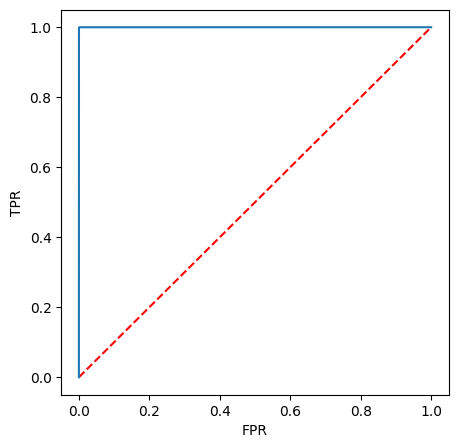

In [89]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lr_model.summary.roc.select('FPR').collect(),
         lr_model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [87]:
predictions.select(['probability']).show(3,truncate=False)

+-------------------------------------------+
|probability                                |
+-------------------------------------------+
|[0.9999999999997708,2.291500322826323E-13] |
|[0.9999999999986438,1.3562484468820912E-12]|
|[0.9999999999986438,1.3562484468820912E-12]|
+-------------------------------------------+
only showing top 3 rows



In [82]:
scoreAndLabels=predictions.select(['probability','label']).rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))

In [86]:
scoreAndLabels.collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 512.0 failed 1 times, most recent failure: Lost task 3.0 in stage 512.0 (TID 5019) (DESKTOP-JNOAOEJ executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 14 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 14 more


In [83]:
from matplotlib import pyplot as plt
%matplotlib inline
bcm = BinaryClassificationMetrics(scoreAndLabels)
# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

c:\wamp64\www\spark_project\venv\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 510.0 failed 1 times, most recent failure: Lost task 0.0 in stage 510.0 (TID 5014) (DESKTOP-JNOAOEJ executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 14 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:189)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:176)
	... 14 more


In [36]:


# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier()
tree_model = tree.fit(train)

# Create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(test)
prediction.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|0    |0.0       |[0.9999965769719209,3.423028079099333E-6]|
|0    |0.0       |[0.9999965769719209,3.423028079099333E-6]|
|0    |0.0       |[0.9999965769719209,3.423028079099333E-6]|
|0    |0.0       |[0.9999965769719209,3.423028079099333E-6]|
|0    |0.0       |[0.9999965769719209,3.423028079099333E-6]|
+-----+----------+-----------------------------------------+
only showing top 5 rows



In [37]:

def evaluate(pred):
    pred.groupBy('label', 'prediction').count().show()

    # Calculate the elements of the confusion matrix
    TN = pred.filter('prediction = 0 AND label = prediction').count()
    TP = pred.filter('prediction = 1 AND label = prediction').count()
    FN = pred.filter('prediction = 0 AND label = 1').count()
    FP = pred.filter('prediction = 1 AND label = 0').count()

    # Accuracy measures the proportion of correct predictions
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    recall = (TP) / (TP+FN)
    precision= (TP) / (TP+FP)
    f1=2*(precision*recall)/(precision+recall)
    print('EVALUATION SUMMARY:')
    print(f'accuracy:{accuracy} \nprecision:{precision} \nrecall:{recall} \nf1-score:{f1}')


In [45]:
evaluate(prediction)

+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    1|       0.0|     33|
|    0|       0.0|1717323|
|    1|       1.0|   6166|
|    0|       1.0|     93|
+-----+----------+-------+

EVALUATION SUMMARY:
accuracy:0.9999268978281113 
precision:0.9851413963891995 
recall:0.9946765607356025 
f1-score:0.9898860170171776


In [40]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
logistic = LogisticRegression()
lr_pipeline = Pipeline(stages=[ logistic])
lr_model=lr_pipeline.fit(train)
lr_prediction=lr_model.transform(test)
lr_prediction.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+-------------------------------------------+
|label|prediction|probability                                |
+-----+----------+-------------------------------------------+
|0    |0.0       |[0.9999999999783138,2.1686208384608108E-11]|
|0    |0.0       |[0.9999999999262756,7.372435995023352E-11] |
|0    |0.0       |[0.9999999997835478,2.1645218950538947E-10]|
|0    |0.0       |[1.0,0.0]                                  |
|0    |0.0       |[0.9999999999999998,2.220446049250313E-16] |
+-----+----------+-------------------------------------------+
only showing top 5 rows



In [41]:
evaluate(lr_prediction)

+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    0|       0.0|1717405|
|    1|       1.0|   6181|
|    0|       1.0|     11|
|    1|       0.0|     18|
+-----+----------+-------+

EVALUATION SUMMARY:
accuracy:0.9999831748969462 
precision:0.9982235142118863 
recall:0.9970963058557832 
f1-score:0.9976595916390929


In [42]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[ rf])
rf_model=pipeline.fit(train)
rf_predictions=rf_model.transform(test)
rf_predictions.select('label', 'prediction', 'probability').show(5, False)

+-----+----------+------------------------------------------+
|label|prediction|probability                               |
+-----+----------+------------------------------------------+
|0    |0.0       |[0.9999644889923797,3.5511007620311594E-5]|
|0    |0.0       |[0.9999720909893208,2.790901067927771E-5] |
|0    |0.0       |[0.9999644889923797,3.5511007620311594E-5]|
|0    |0.0       |[0.9999838082776951,1.6191722304915428E-5]|
|0    |0.0       |[0.9999838082776951,1.6191722304915428E-5]|
+-----+----------+------------------------------------------+
only showing top 5 rows



In [43]:
rf_predictions.columns

['is_match',
 'cmp_fname_c1_imputed',
 'cmp_fname_c2_imputed',
 'cmp_lname_c1_imputed',
 'cmp_lname_c2_imputed',
 'cmp_sex_imputed',
 'cmp_bd_imputed',
 'cmp_bm_imputed',
 'cmp_by_imputed',
 'cmp_plz_imputed',
 'label',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [44]:
evaluate(rf_predictions)

+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    1|       0.0|     73|
|    0|       0.0|1717414|
|    1|       1.0|   6126|
|    0|       1.0|      2|
+-----+----------+-------+

EVALUATION SUMMARY:
accuracy:0.9999564868024472 
precision:0.9996736292428199 
recall:0.9882239070817874 
f1-score:0.9939157945972257


In [ ]:
# todo: implement area under ROC 

# predictionAndLabels = prediction.select('prediction','label').rdd \
#                             .map(lambda x: (x[0],x[1]))


# # Instantiate metrics object
# metrics = BinaryClassificationMetrics(predictionAndLabels)
# # Area under ROC curve
# print("Area under ROC = %s" % metrics.areaUnderROC)

### Cross Validation 

In [46]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [ ]:
lr_cs = LogisticRegression()

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr_cs = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr_cs.regParam, [0.1, 0.01]) \
    .addGrid(lr_cs.fitIntercept, [False, True])\
    .addGrid(lr_cs.elasticNetParam, [0.0, 1.0])\
    .build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr_cs, estimatorParamMaps=grid, evaluator=evaluator)
cvModel = cv.fit(train)
lrprediction=cvModel.transform(test)



print('Accuracy:', evaluator.evaluate(lrprediction))
print('AUC:', BinaryClassificationMetrics(lrprediction['label','prediction'].rdd).areaUnderROC)

In [ ]:
evaluate(lrprediction)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier()
grid = ParamGridBuilder() \
        .addGrid(dt.maxDepth,  [2, 5, 10, 20, 30]) \
        .addGrid(dt.maxBins,  [10, 20, 40, 80, 100]) \
        .build()
dtevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
cv = CrossValidator(estimator=dt, 
                    estimatorParamMaps=grid, 
                    evaluator=dtevaluator,
                    numFolds = 3)
dtModel = cv.fit(train)
dtpredictions = dtModel.transform(test)

print('Accuracy:', dtevaluator.evaluate(dtpredictions))
print('AUC:', BinaryClassificationMetrics(dtpredictions['label','prediction'].rdd).areaUnderROC)

In [ ]:
evaluate(dtpredictions)